In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#MCDM Function


Option   :     Fuel :    Price
======== : ======== : ========
Car      :   -1.000 :    0.000
Bus      :    0.000 :    0.000
Train    :    0.000 :    1.000
======== : ======== : ========

Option   :     Fuel :    Price
======== : ======== : ========
Car      :   -1.000 :    0.000
Bus      :    0.000 :    0.000
Train    :    0.000 :    1.000
======== : ======== : ========

Option   :     Fuel :    Price :   Intuit
======== : ======== : ======== : ========
Car      :   -1.000 :    0.000 :   -1.000
Bus      :    0.000 :    0.000 :    0.000
Train    :    0.000 :    1.000 :    0.100
======== : ======== : ======== : ========

Option   :     Fuel :    Price :   Intuit : Fuel_Hig : Price_Hi
======== : ======== : ======== : ======== : ======== : ========
Car      :   -1.000 :    0.000 :   -1.000 :   -0.667 :   -0.333
Bus      :    0.000 :    0.000 :    0.000 :    0.000 :    0.000
Train    :    0.000 :    1.000 :    0.100 :    0.333 :    0.667
======== : ======== : ======== : ======== : ======== 

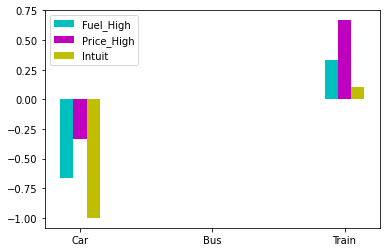

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import HTML

class Mcdm:
    """m = Mcdm(opts)

    Multicriteria decision making aid
    following the 'Pugh' scoring approach
    starting with 'opts' as a tuple of option
    identifiers.

    Example:
      m = Mcdm(('Car', 'Bus', 'Train'))"""

    def __init__(self,opts):
        self.options = opts
        self.scores = {}
        self._criteria = []
    
    def copy(self,reset_scores=False):
        new_mcdm = Mcdm(self.options)
        for (opt,cri) in self.scores.keys():
            new_val = 0.0
            if not reset_scores:
                new_val = self.get_score(opt,cri)
            new_mcdm.set_score(opt,cri,new_val)
        return(new_mcdm)
    
    def __add__(self,other):
        new_mcdm = self.copy()
        for (opt,cri) in other.scores.keys():
            assert (opt in self.options), "No such option: {}".format(opt)
            self_val = self.get_score(opt,cri)
            add_val = other.get_score(opt,cri)
            new_mcdm.set_score(opt,cri,self_val+add_val)
        return(new_mcdm)        
    
    def set_score(self,opt,cri,val):
        """m.set_score(opt,cri,val)

        Set score for option against criterion.
        Will introduce new criterion if not scored
        before, but will fail if option was not
        included at initialization."""
        assert (opt in self.options), "No such option: {}".format(opt)
        self.scores[(opt,cri)]=val
        # and add to critria list
        if not cri in self._criteria:
            self._criteria.append(cri)
            
    def set_scores_dict(self,score_dict):
        """m.set_scores_dict(self,score_dict)
        
        Set multiple scores at once via dictionary.
        Each key should be (opt,cri) and each value
        should be a score.
        Example:
        
        m.set_scores_dict({('Car','Speed'):1,('Car','Comfort'):-1})"""
        for (opt,cri) in score_dict.keys():
            assert (opt in self.options), "No such option: {}".format(opt)
            self.set_score(opt,cri,score_dict[(opt,cri)])
            
    def criteria(self):
        #return(set([cri for (opt,cri) in self.scores]))
        return self._criteria

    def get_score(self,opt,cri):
        assert (opt in self.options), "No such option: {}".format(opt)
        assert (cri in self.criteria()), "No such criterion: {}".format(cri)
        val = 0.0
        if (opt,cri) in self.scores.keys():
            val = self.scores[(opt,cri)]
        return(val)

    def max_score(self):
        return(max([max([self.get_score(opt,cri) for opt in self.options])
 for cri in self.criteria()]))

    def min_score(self):
        return(min([min([self.get_score(opt,cri) for opt in self.options])
 for cri in self.criteria()]))

    def _rescale_all(self):
        """Rescale all scores linearly to range [0,1]"""
        new_mcdm = self.copy()
        mn = self.min_score()
        rg = self.max_score() - mn
        for opt in self.options:
            for cri in self.criteria():
                new_val = (self.get_score(opt,cri) - mn)/rg
                new_mcdm.set_score(opt,cri,new_val)
        return(new_mcdm)

    def _rescale_each_col(self):
        """Rescale each column's scores linearly
        such that each column fills range [0,1]"""
        new_mcdm = self.copy()
        for cri in self.criteria():
            mn = self.select_criteria([cri]).min_score()
            rg = self.select_criteria([cri]).max_score() - mn
            for opt in self.options:
                new_val = (self.get_score(opt,cri) - mn)/rg
                new_mcdm.set_score(opt,cri,new_val)
        return(new_mcdm)

    def rescale(self,by_columns=False):
        """Rescale all scores linearly to range [0,1]"""
        if by_columns:
            return(self._rescale_each_col())
        else:
            return(self._rescale_all())

    def weight_criteria(self,name,weights):
        for cri in weights.keys():
            assert cri in self.criteria(), "No such criterion: {}".format(cri)
        for opt in self.options:
            new_score = sum([weights[cri]*self.get_score(opt,cri) for cri in weights.keys()])
            self.set_score(opt,name,new_score)

    def weight_mixture(self, cri_list=None):
        if cri_list is None:
            cri_list=self.criteria()
        for cri in cri_list:
            assert cri in self.criteria(), "No such criterion: {}".format(cri)
        num_cri = len(cri_list)
        for cri in cri_list:
            this_name = str(cri)+"_High"
            this_weight = {c: 1.0/(1.0+num_cri) for c in cri_list}
            this_weight[cri] = this_weight[cri]*2.0
            self.weight_criteria(this_name,this_weight)

    def select_criteria(self,cri_list):
        for cri in cri_list:
            assert cri in self.criteria(), "No such criterion: {}".format(cri)
        new_mcdm = Mcdm(self.options)
        for cri in cri_list:
            for opt in self.options:
                new_mcdm.set_score(opt,cri,self.get_score(opt,cri))
        return(new_mcdm)
    
    def select_options(self,opt_list):
        for opt in opt_list:
            assert opt in self.options, "No such criterion: {}".format(opt)
        new_mcdm = Mcdm(opt_list)
        for cri in self.criteria():
            for opt in opt_list:
                new_mcdm.set_score(opt,cri,self.get_score(opt,cri))
        return(new_mcdm)

    def plot(self,show=True):
        width=0.1
        colors=['c','m','y','k','b','r','g']
        fig,ax = plt.subplots()
        for (ii,cri) in enumerate(self.criteria()):
            cri_ind = [jj+ii*width for jj in range(len(self.options))]
            cri_score = [self.get_score(opt,cri) for opt in self.options]
            ax.bar(cri_ind,cri_score,width,color=colors[ii%len(colors)],label=str(cri))
        ax.set_xticks([jj+0.5*ii*width for jj in range(len(self.options))])
        ax.set_xticklabels(self.options)
        ax.legend()
        if show:
            plt.show()
        return(ax)

    def __repr__(self):
        opt_fmt='{:8}'
        cri_name_fmt='{:>8.8}'
        cri_val_fmt='{:8.3f}'
        sep = ' : '
        header = opt_fmt.format('Option') + sep + sep.join([cri_name_fmt.format(cri) for cri in self.criteria()]) + '\n'
        rows = '\n'.join([opt_fmt.format(opt) + sep + sep.join([cri_val_fmt.format(self.get_score(opt,cri)) for cri in self.criteria()]) for opt in self.options]) + '\n'
        row_sep = '='*8 + sep + sep.join(['='*8 for cri in self.criteria()]) + '\n'
        return(header+row_sep+rows+row_sep)

    def _raw_html(self):
        table_start = '<table>\n'
        header = '<tr><th>{}</th>'.format('Option') + ' '.join(['<th>{}</th>'.format(cri) for cri in self.criteria()]) + '</tr>\n'
        rows = '\n'.join(['<tr><th>{}</th>'.format(opt) + ' '.join(['<td>{:8.3f}</td>'.format(self.get_score(opt,cri)) for cri in self.criteria()]) + '</tr>' for opt in self.options])
        table_stop = '\n</table>\n'
        return(table_start+header+rows+table_stop)

    def to_html(self):
        return(HTML(self._raw_html()))
    
def travel_example():
    travel = Mcdm(('Car','Bus','Train'))
    travel.set_score('Car','Fuel',-1.0)
    travel.set_score('Train','Price',1.0)
    print(travel)
    travel.rescale()
    print(travel)
    travel.weight_criteria('Intuit',{'Fuel': 1.0, 'Price': 0.1})
    print(travel)
    travel.weight_mixture(['Fuel','Price'])
    print(travel)
    print(travel.select_criteria(['Fuel_High','Price_High','Intuit']))
    travel.select_criteria(['Fuel_High','Price_High','Intuit']).plot()
    return(travel)

if __name__=='__main__':
    t=travel_example()


#HQM Score

In [ ]:
read_file = pd.read_excel ("momentum_strategy.xlsx")

In [ ]:
read_file.to_csv ("momentum_strategy.csv",
				index = None,
				header=True)

df = pd.DataFrame(pd.read_csv("momentum_strategy.csv",nrows=10))
y = ['One-Year Price Return', 'Six-Month Price Return','Three-Month Price Return','One-Month Price Return', 'HQM']
df = df.drop(y,axis=1)
df

,Ticker,Price,One-Year Return Percentile,Six-Month Return Percentile,Three-Month Return Percentile,One-Month Return Percentile
0,A,159.83,0.685149,0.712871,0.516832,0.041584
1,AAL,19.48,0.716832,0.146535,0.095050,0.019802
2,AAP,240.10,0.702970,0.718812,0.651485,0.728713
3,AAPL,155.20,0.451485,0.607921,0.384158,0.417822
4,ABBV,109.10,0.518812,0.310891,0.140594,0.508911
5,ABC,127.80,0.388119,0.388119,0.435644,0.358416
6,ABMD,367.57,0.392079,0.366337,0.657426,0.413861
7,ABT,131.24,0.312871,0.431683,0.564356,0.485149
8,ACN,358.58,0.748515,0.831683,0.790099,0.675248
9,ADBE,678.99,0.479208,0.873267,0.497030,0.590099


In [ ]:
for i in df.index:
  df.loc[i,'Price'] = df.loc[i,'Price'] * (-1)
df

,Ticker,Price,One-Year Return Percentile,Six-Month Return Percentile,Three-Month Return Percentile,One-Month Return Percentile
0,A,-159.83,0.685149,0.712871,0.516832,0.041584
1,AAL,-19.48,0.716832,0.146535,0.095050,0.019802
2,AAP,-240.10,0.702970,0.718812,0.651485,0.728713
3,AAPL,-155.20,0.451485,0.607921,0.384158,0.417822
4,ABBV,-109.10,0.518812,0.310891,0.140594,0.508911
5,ABC,-127.80,0.388119,0.388119,0.435644,0.358416
6,ABMD,-367.57,0.392079,0.366337,0.657426,0.413861
7,ABT,-131.24,0.312871,0.431683,0.564356,0.485149
8,ACN,-358.58,0.748515,0.831683,0.790099,0.675248
9,ADBE,-678.99,0.479208,0.873267,0.497030,0.590099


In [ ]:
tickerval = df['Ticker'].tolist()
tickerval

['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE']

In [ ]:
uav = Mcdm(tickerval)
uav.to_html()

Option
A
AAL
AAP
AAPL
ABBV
ABC
ABMD
ABT
ACN
ADBE


In [ ]:
columns = list(df.columns.values)
columns.pop(0)
columns

['Price',
 'One-Year Return Percentile',
 'Six-Month Return Percentile',
 'Three-Month Return Percentile',
 'One-Month Return Percentile']

In [ ]:
for tick in range(len(tickerval)):
  for col in columns:
    uav.set_score(df.loc[tick, 'Ticker'],col, df.loc[tick, col])
uav.to_html()


Option,Price,One-Year Return Percentile,Six-Month Return Percentile,Three-Month Return Percentile,One-Month Return Percentile
A,-159.830,0.685,0.713,0.517,0.042
AAL,-19.480,0.717,0.147,0.095,0.020
AAP,-240.100,0.703,0.719,0.651,0.729
AAPL,-155.200,0.451,0.608,0.384,0.418
ABBV,-109.100,0.519,0.311,0.141,0.509
ABC,-127.800,0.388,0.388,0.436,0.358
ABMD,-367.570,0.392,0.366,0.657,0.414
ABT,-131.240,0.313,0.432,0.564,0.485
ACN,-358.580,0.749,0.832,0.790,0.675
ADBE,-678.990,0.479,0.873,0.497,0.590


In [ ]:
uav_01=uav.rescale(by_columns=True)
uav_01.to_html()

Option,Price,One-Year Return Percentile,Six-Month Return Percentile,Three-Month Return Percentile,One-Month Return Percentile
A,0.787,0.855,0.779,0.607,0.031
AAL,1.000,0.927,0.000,0.000,0.000
AAP,0.665,0.895,0.787,0.801,1.000
AAPL,0.794,0.318,0.635,0.416,0.561
ABBV,0.864,0.473,0.226,0.066,0.690
ABC,0.836,0.173,0.332,0.490,0.478
ABMD,0.472,0.182,0.302,0.809,0.556
ABT,0.831,0.000,0.392,0.675,0.656
ACN,0.486,1.000,0.943,1.000,0.925
ADBE,0.000,0.382,1.000,0.578,0.804


<Figure size 3600x3600 with 0 Axes>

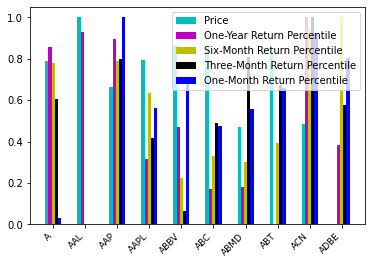

In [ ]:
plt.figure(figsize=(50, 50))
ax = uav_01.plot(show=False)
xt=ax.set_xticklabels(tickerval,{'fontsize':9, }, rotation=45, ha='right')

In [ ]:
default_weight = 1.0/len(uav.criteria())
weights_vector = {}
for i in range(len(uav.criteria())):
  for col in columns:
    weights_vector[col] = default_weight
 
weights_vector
#weight_vector={' + ',\n'.join(["\'{}\': {}".format(cri,default_weight) for cri in uav.criteria()]) + '}

{'One-Month Return Percentile': 0.2,
 'One-Year Return Percentile': 0.2,
 'Price': 0.2,
 'Six-Month Return Percentile': 0.2,
 'Three-Month Return Percentile': 0.2}

In [ ]:
uav_01.weight_criteria('Intuition',weights_vector)
uav_01.select_criteria(['Intuition']).to_html()

Option,Intuition
A,0.612
AAL,0.385
AAP,0.830
AAPL,0.545
ABBV,0.464
ABC,0.462
ABMD,0.464
ABT,0.511
ACN,0.871
ADBE,0.553


In [ ]:
uav_01

Option   :    Price : One-Year : Six-Mont : Three-Mo : One-Mont : Intuitio
======== : ======== : ======== : ======== : ======== : ======== : ========
A        :    0.787 :    0.855 :    0.779 :    0.607 :    0.031 :    0.612
AAL      :    1.000 :    0.927 :    0.000 :    0.000 :    0.000 :    0.385
AAP      :    0.665 :    0.895 :    0.787 :    0.801 :    1.000 :    0.830
AAPL     :    0.794 :    0.318 :    0.635 :    0.416 :    0.561 :    0.545
ABBV     :    0.864 :    0.473 :    0.226 :    0.066 :    0.690 :    0.464
ABC      :    0.836 :    0.173 :    0.332 :    0.490 :    0.478 :    0.462
ABMD     :    0.472 :    0.182 :    0.302 :    0.809 :    0.556 :    0.464
ABT      :    0.831 :    0.000 :    0.392 :    0.675 :    0.656 :    0.511
ACN      :    0.486 :    1.000 :    0.943 :    1.000 :    0.925 :    0.871
ADBE     :    0.000 :    0.382 :    1.000 :    0.578 :    0.804 :    0.553
======== : ======== : ======== : ======== : ======== : ======== : ========

Ranked order:  ['ACN', 'AAP', 'A', 'ADBE', 'AAPL', 'ABT', 'ABMD', 'ABBV', 'ABC', 'AAL']


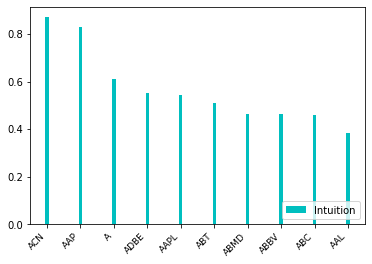

In [ ]:
score_list = ['Intuition']

def tot_score(opt):
    return sum([uav_01.get_score(opt,cri) for cri in score_list])

sorted_opts = sorted(tickerval,key=tot_score,reverse=True)
print('Ranked order: ', sorted_opts)
num_to_plot = 10 # max is ten
ax=uav_01.select_options(sorted_opts[0:num_to_plot]).select_criteria(score_list).plot(show=False)
ax.set_xticklabels(sorted_opts[0:num_to_plot],{'fontsize':9, }, rotation=45, ha='right')
ax.legend(loc='lower right')

#RV Score


In [ ]:
read_file = pd.read_excel ("value_strategy.xlsx")

In [ ]:
read_file.to_csv ("value_strategy.csv",
				index = None,
				header=True)

df1 = pd.DataFrame(pd.read_csv("value_strategy.csv",nrows=10))
y = ['Price-to-Earnings Ratio', 'Price-to-Book Ratio','Price-to-Sales Ratio','EV/EBITDA','EV/GP']
df1 = df1.drop(y,axis=1)

In [ ]:
for i in df1.index:
  df1.loc[i,'Price'] = df1.loc[i,'Price'] * (-1)
df1

,Ticker,Price,PE Percentile,PB Percentile,PS Percentile,EV/EBITDA Percentile,EV/GP Percentile,RV
0,A,-159.27,0.833663,0.797030,0.811881,0.883168,0.825743,8.302970
1,AAL,-20.19,0.071287,0.049505,0.035644,0.027723,0.059406,0.487129
2,AAP,-237.25,0.469307,0.557426,0.173267,0.372277,0.138614,3.421782
3,AAPL,-155.31,0.600000,0.960396,0.792079,0.742574,0.893069,7.976238
4,ABBV,-109.70,0.568317,0.885149,0.521782,0.277228,0.463366,5.431683
5,ABC,-128.50,0.063366,1.000000,0.005941,0.239604,0.259406,3.136634
6,ABMD,-360.06,0.960396,0.849505,0.960396,0.954455,0.920792,9.291089
7,ABT,-132.25,0.691089,0.722772,0.685149,0.770297,0.679208,7.097030
8,ACN,-360.66,0.751485,0.837624,0.629703,0.734653,0.784158,7.475248
9,ADBE,-664.82,0.857426,0.930693,0.974257,0.950495,0.958416,9.342574


In [ ]:
tickerval = df1['Ticker'].tolist()
tickerval

['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE']

In [ ]:
uav = Mcdm(tickerval)
uav.to_html()

Option
A
AAL
AAP
AAPL
ABBV
ABC
ABMD
ABT
ACN
ADBE


In [ ]:
columns = list(df1.columns.values)
columns.pop(0)
columns.pop()
columns

['Price',
 'PE Percentile',
 'PB Percentile',
 'PS Percentile',
 'EV/EBITDA Percentile',
 'EV/GP Percentile']

In [ ]:
for tick in range(len(tickerval)):
  for col in columns:
    uav.set_score(df1.loc[tick, 'Ticker'],col, df1.loc[tick, col])
uav.to_html()


Option,Price,PE Percentile,PB Percentile,PS Percentile,EV/EBITDA Percentile,EV/GP Percentile
A,-159.270,0.834,0.797,0.812,0.883,0.826
AAL,-20.190,0.071,0.050,0.036,0.028,0.059
AAP,-237.250,0.469,0.557,0.173,0.372,0.139
AAPL,-155.310,0.600,0.960,0.792,0.743,0.893
ABBV,-109.700,0.568,0.885,0.522,0.277,0.463
ABC,-128.500,0.063,1.000,0.006,0.240,0.259
ABMD,-360.060,0.960,0.850,0.960,0.954,0.921
ABT,-132.250,0.691,0.723,0.685,0.770,0.679
ACN,-360.660,0.751,0.838,0.630,0.735,0.784
ADBE,-664.820,0.857,0.931,0.974,0.950,0.958


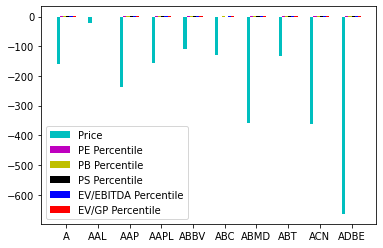

In [ ]:
uav.plot()

In [ ]:
uav_01=uav.rescale(by_columns=True)
uav_01.to_html()

Option,Price,PE Percentile,PB Percentile,PS Percentile,EV/EBITDA Percentile,EV/GP Percentile
A,0.784,0.859,0.786,0.832,0.923,0.852
AAL,1.000,0.009,0.000,0.031,0.000,0.000
AAP,0.663,0.453,0.534,0.173,0.372,0.088
AAPL,0.790,0.598,0.958,0.812,0.771,0.927
ABBV,0.861,0.563,0.879,0.533,0.269,0.449
ABC,0.832,0.000,1.000,0.000,0.229,0.222
ABMD,0.473,1.000,0.842,0.986,1.000,0.958
ABT,0.826,0.700,0.708,0.701,0.801,0.689
ACN,0.472,0.767,0.829,0.644,0.763,0.806
ADBE,0.000,0.885,0.927,1.000,0.996,1.000


<Figure size 3600x3600 with 0 Axes>

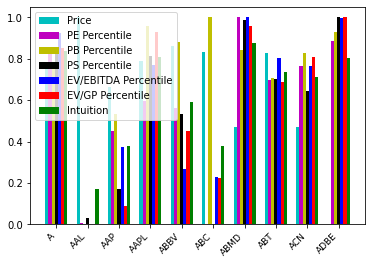

In [ ]:
plt.figure(figsize=(50, 50))
ax = uav_01.plot(show=False)
xt=ax.set_xticklabels(tickerval,{'fontsize':9, }, rotation=45, ha='right')

In [ ]:
default_weight = 1.0/len(uav.criteria())
weights_vector = {}
for i in range(len(uav.criteria())):
  for col in columns:
    weights_vector[col] = default_weight
 
weights_vector
#weight_vector={' + ',\n'.join(["\'{}\': {}".format(cri,default_weight) for cri in uav.criteria()]) + '}

{'EV/EBITDA Percentile': 0.16666666666666666,
 'EV/GP Percentile': 0.16666666666666666,
 'PB Percentile': 0.16666666666666666,
 'PE Percentile': 0.16666666666666666,
 'PS Percentile': 0.16666666666666666,
 'Price': 0.16666666666666666}

In [ ]:
uav_01.weight_criteria('Intuition',weights_vector)
uav_01.select_criteria(['Intuition']).to_html()

Option,Intuition
A,0.840
AAL,0.173
AAP,0.380
AAPL,0.810
ABBV,0.592
ABC,0.381
ABMD,0.876
ABT,0.738
ACN,0.714
ADBE,0.801


In [ ]:
uav_01

Option   :    Price : PE Perce : PB Perce : PS Perce : EV/EBITD : EV/GP Pe : Intuitio
======== : ======== : ======== : ======== : ======== : ======== : ======== : ========
A        :    0.784 :    0.859 :    0.786 :    0.832 :    0.923 :    0.852 :    0.840
AAL      :    1.000 :    0.009 :    0.000 :    0.031 :    0.000 :    0.000 :    0.173
AAP      :    0.663 :    0.453 :    0.534 :    0.173 :    0.372 :    0.088 :    0.380
AAPL     :    0.790 :    0.598 :    0.958 :    0.812 :    0.771 :    0.927 :    0.810
ABBV     :    0.861 :    0.563 :    0.879 :    0.533 :    0.269 :    0.449 :    0.592
ABC      :    0.832 :    0.000 :    1.000 :    0.000 :    0.229 :    0.222 :    0.381
ABMD     :    0.473 :    1.000 :    0.842 :    0.986 :    1.000 :    0.958 :    0.876
ABT      :    0.826 :    0.700 :    0.708 :    0.701 :    0.801 :    0.689 :    0.738
ACN      :    0.472 :    0.767 :    0.829 :    0.644 :    0.763 :    0.806 :    0.714
ADBE     :    0.000 :    0.885 :    0.927 :    1.000 :

Ranked order:  ['ABMD', 'A', 'AAPL', 'ADBE', 'ABT', 'ACN', 'ABBV', 'ABC', 'AAP', 'AAL']


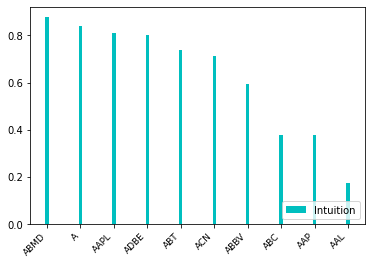

In [ ]:
score_list = ['Intuition']

def tot_score(opt):
    return sum([uav_01.get_score(opt,cri) for cri in score_list])

sorted_opts = sorted(tickerval,key=tot_score,reverse=True)
print('Ranked order: ', sorted_opts)
num_to_plot = 10 # max is ten
ax=uav_01.select_options(sorted_opts[0:num_to_plot]).select_criteria(score_list).plot(show=False)
ax.set_xticklabels(sorted_opts[0:num_to_plot],{'fontsize':9, }, rotation=45, ha='right')
ax.legend(loc='lower right')